<a href="https://colab.research.google.com/github/rrl7012005/Competitions-and-Datasets/blob/main/Kaggle_IceBerg_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
import numpy as np
import opendatasets as od
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
od.download('https://www.kaggle.com/competitions/statoil-iceberg-classifier-challenge')

100%|██████████| 288M/288M [00:03<00:00, 84.7MB/s]



Extracting archive ./statoil-iceberg-classifier-challenge/statoil-iceberg-classifier-challenge.zip to ./statoil-iceberg-classifier-challenge


#Data Inspection, Visualization, Loading

In [ ]:
import pathlib

data_dir = pathlib.Path('/content/statoil-iceberg-classifier-challenge')

train_dir = data_dir / 'train.json.7z'
test_dir = data_dir / 'test.json.7z'

train_dir

PosixPath('/content/statoil-iceberg-classifier-challenge/train.json.7z')

In [ ]:
!apt-get install p7zip-full
!7z x "{train_dir}" -o"{data_dir}"
!7z x "{test_dir}" -o"{data_dir}"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/statoil-iceberg-classifier-challenge/                                                        1 file, 44932785 bytes (43 MiB)

Extracting archive: /content/statoil-iceberg-classifier-challenge/train.json.7z
--
Path = /content/statoil-iceberg-classifier-challenge/train.json.7z
Type = 7z
Physical Size = 44932785
Headers Size = 154
Method = LZMA2:24
Solid = -
Blocks = 1

  0%      0% - data/processed/train.json

In [ ]:
import json

data_dir = pathlib.Path('/content/statoil-iceberg-classifier-challenge/data/processed')
train_dir = data_dir / 'train.json'
test_dir = data_dir / 'test.json'

with open(train_dir, 'r') as file:
  train_json = json.load(file)

with open(test_dir, 'r') as file:
  test_json = json.load(file)

Investigate the json file

In [ ]:
type(train_json)

list

In [ ]:
len(train_json), len(test_json)

(1604, 8424)

In [ ]:
import random
random.shuffle(train_json)

In [ ]:
val_json = train_json[1412:].copy()
train_json = train_json[:1412].copy()

len(val_json), len(train_json), len(test_json)

(192, 1412, 8424)

Normalize the input images

In [ ]:
def process_dataset(data):
    band1 = np.array([np.array(i['band_1']).reshape(75,75) for i in data])
    band2 = np.array([np.array(i['band_2']).reshape(75,75) for i in data])

    band3 = (band1 + band2) / 2

    band1 = (band1 - np.min(band1)) / (np.max(band1) - np.min(band1))
    band2 = (band2 - np.min(band2)) / (np.max(band2) - np.min(band2))

    band3 = (band3 - np.min(band3)) / (np.max(band3) - np.min(band3))

    stacked_images = np.stack((band1, band2, band3), axis=-1)

    return stacked_images


train_images = process_dataset(train_json)
val_images = process_dataset(val_json)
test_images = process_dataset(test_json)

train_images.shape, val_images.shape, test_images.shape

((1412, 75, 75, 3), (192, 75, 75, 3), (8424, 75, 75, 3))

In [ ]:
train_labels = np.array([img['is_iceberg'] for img in train_json])
val_labels = np.array([img['is_iceberg'] for img in val_json])

#Data Augmentation

In [ ]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, RandomContrast, RandomBrightness, RandomCrop


# augment_layers = tf.keras.Sequential([
#     RandomFlip("horizontal_and_vertical"),
#     RandomRotation(factor=(-0.5, 0.5)),
#     RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
#     # RandomTranslation(height_factor=0.1, width_factor=0.1),
#     # RandomCrop(height=75, width=75),
# ])

def add_gaussian_noise(image):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01, dtype=tf.float32)
    return tf.clip_by_value(image + noise, 0.0, 1.0)


def augmentation(image, label):
  image = add_gaussian_noise(image)
  return augment_layers(image), label

**Visualize the augmentation**

(75, 75, 2)
0


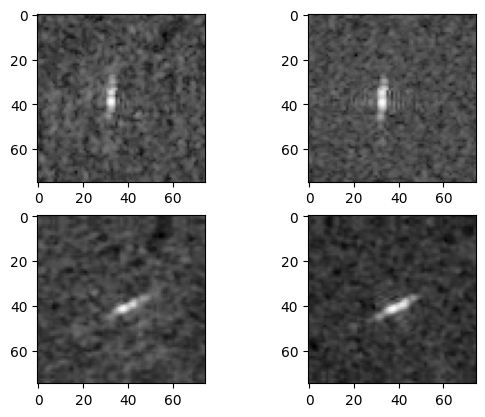

In [ ]:
def visualize(original, augmented):
  plt.subplot(2,2,1)
  plt.imshow(original[:, :, 0], cmap='gray')

  plt.subplot(2,2,2)
  plt.imshow(original[:, :, 1], cmap='gray')

  plt.subplot(2,2,3)
  plt.imshow(augmented[:, :, 0], cmap='gray')

  plt.subplot(2,2,4)
  plt.imshow(augmented[:, :, 1], cmap='gray')

img_o = train_images[160]
print(img_o.shape)
img_a, _ = augmentation(img_o, 1)

print(train_labels[160])
visualize(img_o, img_a)

In [ ]:
def create_dataset(images_train, images_val, images_test, train_labels, val_labels, angles=None, batch_size=32, shuffle=True):

    images_train = tf.convert_to_tensor(images_train, dtype=tf.float32)
    images_val = tf.convert_to_tensor(images_val, dtype=tf.float32)
    images_test = tf.convert_to_tensor(images_test, dtype=tf.float32)

    train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
    val_labels = tf.convert_to_tensor(val_labels, dtype=tf.float32)

    tds = tf.data.Dataset.from_tensor_slices((images_train, train_labels))
    vds = tf.data.Dataset.from_tensor_slices((images_val, val_labels))
    testds = tf.data.Dataset.from_tensor_slices((images_test,))

    if shuffle:
        tds = tds.shuffle(buffer_size=len(images_train))
        vds = vds.shuffle(buffer_size=len(images_val))

    tds = tds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    vds = vds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    testds = testds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return tds, vds, testds

train_dataset, val_dataset, test_dataset = create_dataset(train_images, val_images, test_images, train_labels, val_labels, batch_size=32, shuffle=True)

**Inspect the dataset**

In [ ]:
img, label = next(iter(val_dataset))

(-0.5, 74.5, 74.5, -0.5)

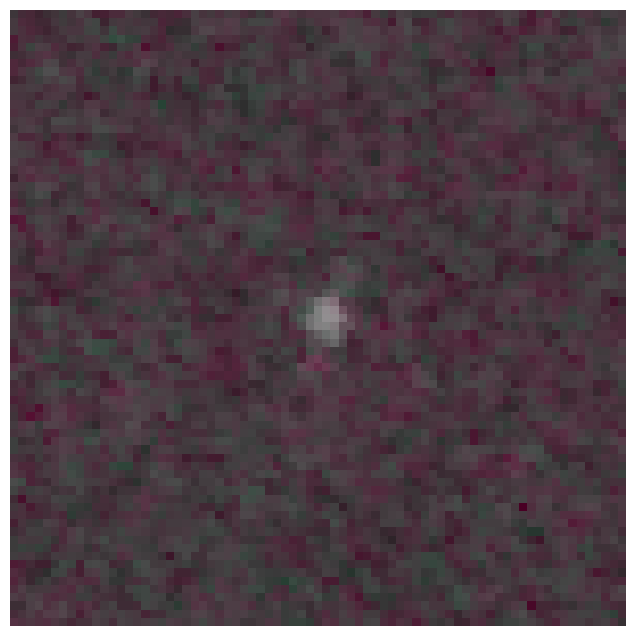

In [ ]:
band1 = img[0, :, :, 0]
band2 = img[0, :, :, 1]
band3 = img[0, :, :, 2]


x = np.stack((band1, band2, band3), axis=-1)
x.shape

plt.figure(figsize = (8,8))

plt.imshow(x)
plt.axis('off')

#Modelling and Training

In [ ]:
from tensorflow.keras.layers import Conv2D, InputLayer, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(75, 75, 2)),

    Conv2D(6, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    Conv2D(12, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(12, (3, 3), activation='relu', padding='valid'),
    BatchNormalization(),
    Conv2D(24, (2, 2), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(24, (2, 2), activation='relu', padding='valid'),
    BatchNormalization(),
    Conv2D(48, (2, 2), activation='relu', padding='valid'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 73, 73, 6)           │             114 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 71, 71, 12)          │             660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 71, 71, 12)          │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 35, 35, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 33, 33, 12)          │           1,308 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 33, 33, 12)          │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 24)          │           1,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 15, 15, 24)          │           2,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 15, 15, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 48)          │           4,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2352)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         301,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 313,231 (1.19 MB)

 Trainable params: 312,979 (1.19 MB)

 Non-trainable params: 252 (1008.00 B)

Lets create a simpler model first

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(75, 75, 2)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),
    Dropout(0.5),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)                   │ (None, 75, 75, 32)          │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_56 (Conv2D)                   │ (None, 75, 75, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 37, 37, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_67               │ (None, 37, 37, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 37, 37, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_68               │ (None, 37, 37, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_69               │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_70               │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,292,097 (12.56 MB)

 Trainable params: 3,289,089 (12.55 MB)

 Non-trainable params: 3,008 (11.75 KB)

**Online Models**

In [ ]:
from tensorflow.keras.layers import Activation

model = tf.keras.Sequential([
    InputLayer(input_shape=(75, 75, 2)),

    Conv2D(64, (3, 3), padding='valid'),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 73, 73, 64)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 34, 34, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 15, 15, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 5, 5, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_16 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 559,617 (2.13 MB)

 Trainable params: 559,617 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model=tf.keras.Sequential()

    # CNN 1

model.add(InputLayer(input_shape=(75,75,3)))
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Dropout(0.2))

    # CNN 2
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

    # CNN 4
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

    # You must flatten the data for the dense layers
model.add(Flatten())

    # Dense 1
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

    # Dense 2
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

    # Output
model.add(Dense(1, activation="sigmoid"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=35,
                    validation_data=val_dataset)

Epoch 1/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 767ms/step - accuracy: 0.5081 - loss: 0.6953 - val_accuracy: 0.5156 - val_loss: 0.6855
Epoch 2/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 731ms/step - accuracy: 0.5399 - loss: 0.6778 - val_accuracy: 0.6823 - val_loss: 0.6213
Epoch 3/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 764ms/step - accuracy: 0.6674 - loss: 0.5810 - val_accuracy: 0.7344 - val_loss: 0.5132
Epoch 4/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 715ms/step - accuracy: 0.7803 - loss: 0.4547 - val_accuracy: 0.6458 - val_loss: 0.8874
Epoch 5/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 724ms/step - accuracy: 0.7356 - loss: 0.5369 - val_accuracy: 0.7812 - val_loss: 0.4770
Epoch 6/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 758ms/step - accuracy: 0.8204 - loss: 0.4064 - val_accuracy: 0.7656 - val_loss: 0.5663
Epoch 7/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 735ms/step - accuracy: 0.8337 - loss: 0.3852 - val_accuracy: 0.8229 - val_loss: 0.4326
Epoch 8/35
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 767ms/step - accuracy: 0.8139 - loss: 0.4092 - val_accu

KeyboardInterrupt: 

**Plotting**

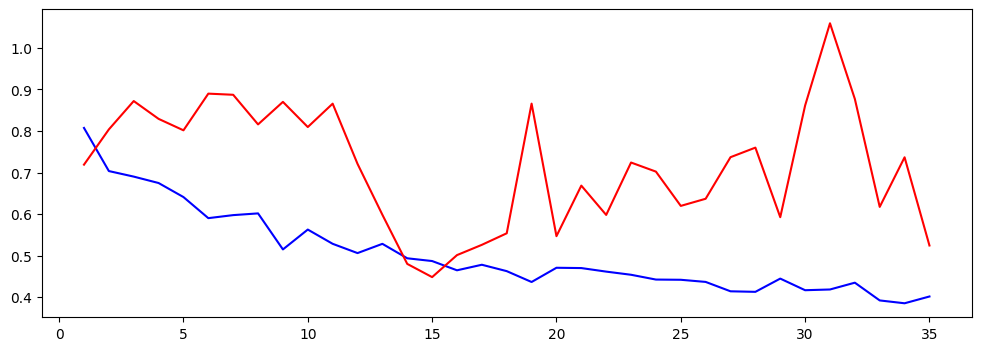

In [ ]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.show()

#Predictions

In [ ]:
predictions = model.predict(test_images)
predictions.flatten()

264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


array([0.43618387, 0.578897  , 0.39047903, ..., 0.609197  , 0.5857121 ,
       0.588624  ], dtype=float32)

In [ ]:
test_ids = [x["id"] for x in test_json]
test_ids = np.array(test_ids)

submission = pd.DataFrame({
    'id': test_ids,
    'is_iceberg': predictions.flatten()
})

submission.to_csv('submission.csv', index=False)

submission.head()

,id,is_iceberg
0,5941774d,0.026446
1,4023181e,0.481242
2,b20200e4,0.377165
3,e7f018bb,0.736345
4,4371c8c3,0.853810
